***

# Geothermal Well Test Analysis with Python
### Notebook 4: Fluid velocity analysis and feed zone interpretation
#### Irene Wallis and Katie McLean 
#### Software Underground, Transform 2021

***

## 15. Feed zone interpretation in geothermal wells

Geothermal wells typically have very long sections of perforated liner (often longer than 1km). This entire length is potentially open to fluid flow from (or into) the reservoir, though whether there is actually any flow at a particular depth during production (or injection) depends on whether there is permeability in the reservoir at that depth. In typical geothermal wells in NZ (and elsewhere) there are multiple distinct depths at which there is permeability - called "permeable feed zones", or just "feed zones". See Figure 4 of the introductory notebook for a schematic of a geothermal well showing feed zones. 

It is of interest to know the depths and relative sizes of the feed zones. This allows the geothermal reservoir engineer to correlate feed zones to geological formations to improve future well targeting, accurately model the well and its likely future performance, and maintain the well into the future (if targeted well stimulations are required), for example. 

Feed zones are interpreted from various data which can be collected from the surface via PTS (pressure-temperature-spinner) wireline tools. This typically includes: 
- Temperature profiles during injection, at different flow rates.
- Spinner profiles during injection, used to calculate fluid velocity profiles for different flow rates.
- Pressure and temperature profiles during progressive heat-up after injection stops. 
- Fracture datasets from borehole imaging (if available). 

Feed zones are initially interpreted from the data types above, which are captured during completion testing (injection) and heat-up. Later during output testing, PTS data are captured as the well is producing, and this data confirms which of the feed zones are active under those conditions. 

*** 

***

### Google Colab Setup

If you are using Google Colab to run this notebook, we assume you have already followed the Google Colab setup steps outlined [here](https://github.com/ICWallis/T21-Tutoral-WellTestAnalysis).

Because we are importing data, we need to "mount your Google Drive", which is where we tell this notebook to look for the data files. You will need to mount the Google Drive into each notebook.  

1. Run the cell below. If you are not in Google Colab, running the cell below will just return an error that says "No module named 'google'"

2. Follow the link generated by running this code. That link will ask you to sign in to your google account (use the one where you have saved these tutorial materials in) and to allow this notebook access to your google drive. 

3. Completing step 2 above will generate a code. Copy this code, paste below where it says "Enter your authorization code:", and press ENTER. 

Congratulations, this notebook can now import data!

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

***

# 16. Import, munge and check data

## 16.1 Use bespoke functions to import and munge data

Install packages required for this notebook. If you do not already have iapws in your environment, then you will need to pip install it.

In [2]:
!pip install iapws

In [65]:
import pytz
import iapws # steam tables
import openpyxl
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image
from ipywidgets import interactive, Layout, FloatSlider

In [59]:
def read_flowrate(filename):
    ''' 
    Read PTS-2-injection-rate.xlsx in as a pandas dataframe and munge for analysis

    args: filename is r'PTS-2-injection-rate.xlsx'

    returns: pandas dataframe with local NZ datetime and flowrate in t/hr
    '''
    df = pd.read_excel(filename, header=1) 
    df.columns = ['raw_datetime','flow_Lpm']

    list = []
    for date in df['raw_datetime']:
        newdate = datetime.fromisoformat(date)
        list.append(newdate)
    df['ISO_datetime'] = list 

    list = []
    for date in df.ISO_datetime:
        newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
        list.append(newdate)
    df['datetime'] = list

    df['flow_tph'] = df.flow_Lpm * 0.060

    df['timestamp'] = datetime_to_timestamp(df.datetime)

    df.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

    return df



def read_pts(filename):
    '''
    Read PTS-2.xlsx in as a Pandas dataframe and munge for analysis

    args: filename is r'PTS-2.xlsx'

    returns: Pandas dataframe with datetime (local) and key coloumns of PTS data with the correct dtype
    '''
    df = pd.read_excel(filename)

    dict = {
        'DEPTH':'depth_m',
        'SPEED': 'speed_mps',
        'Cable Weight': 'cweight_kg',
        'WHP': 'whp_barg',
        'Temperature': 'temp_degC',
        'Pressure': 'pressure_bara',
        'Frequency': 'frequency_hz'
    }
    df.rename(columns=dict, inplace=True)

    df.drop(0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    list = []
    for date in df.Timestamp:
        newdate = openpyxl.utils.datetime.from_excel(date)
        list.append(newdate)
    df['datetime'] = list

    df.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)
    
    df[
        ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ] = df[
        ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
        ].apply(pd.to_numeric)
    
    df['timestamp'] = datetime_to_timestamp(df.datetime)

    return df

# list of timezones for pytz
# https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
# Pacific/Auckland

def datetime_to_timestamp(dataframe_col):
    '''
    Make Unix timestamp from Python datetime object

    args: dataframe column containing datetime objects

    returns: list of Unix timestamp floats 
    '''
    list = []
    for date in dataframe_col:
        timestamp = datetime.timestamp(date)
        list.append(timestamp)
    return list



def timestamp_to_datetime(dataframe_col):
    '''
    Make Python datetime object from Unix timestamp

    args: dataframe column containing Unix timestamps

    returns: list of datetime objects 
    '''
    list = []
    for date in dataframe_col:
        newdate = datetime.fromtimestamp(date)
        # then into local NZ timezone 
        list.append(newdate)
    return list



def append_flowrate_to_pts(flowrate_df, pts_df):
    '''
    Add surface flowrate to pts data

    Note that the flowrate data is recorded at a courser time resolution than the pts data
    The function makes a linear interpolation to fill the data gaps
    Refer to bonus-combine-data.ipynb to review this method and adapt it for your own data

    Args:   flowrate and pts dataframes generated by the read_flowrate and read_pts functions

    Returns: pts dataframe with flowrate tph added
    
    '''
    flowrate_df = flowrate_df.set_index('timestamp')
    pts_df = pts_df.set_index('timestamp')
    combined_df = pts_df.join(flowrate_df, how = 'outer',  lsuffix = '_pts', rsuffix = '_fr')
    combined_df.drop(columns = ['datetime_fr'], inplace = True)
    combined_df.columns = ['depth_m', 'speed_mps', 'cweight_kg', 'whp_barg', 'temp_degC',
       'pressure_bara', 'frequency_hz', 'datetime', 'flow_tph']
    combined_df['interpolated_flow_tph'] = combined_df['flow_tph'].interpolate(method='linear')
    trimmed_df = combined_df[combined_df['depth_m'].notna()]
    trimmed_df.reset_index(inplace=True)
    return trimmed_df



def find_index(value, df, colname):
    '''
    Find the dataframe index for the exact matching value or nearest two values

    args:   value: (float or int) the search term
            df: (obj) the name of the dataframe that is searched
            colname: (str) the name of the coloum this is searched

    returns:  dataframe index(s) for the matching value or the two adjacent values
              rows can be called from a df using df.iloc[[index_number,index_number]]
    '''
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_index = df[df[colname] < value][colname].idxmax()
        upperneighbour_index = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_index, upperneighbour_index] 


The cells below will take a little while to run because it includes all steps required to import and munge the data (i.e., everything we did in notebook 1).

In [60]:
# Use this method if you are running this notebook in Google Colab
#flowrate = read_flowrate(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-FlowRate.xlsx')

# Use this method if you are running this notebook locally (Anaconda)
flowrate = read_flowrate(r'Data-FlowRate.xlsx')

AttributeError: type object 'datetime.datetime' has no attribute 'toutctimestamp'

In [6]:
# Use this method if you are running this notebook in Google Colab
#pts = read_pts(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-PTS.xlsx')

# Use this method if you are running this notebook locally (Anaconda)
pts = read_pts(r'Data-PTS.xlsx')

In [7]:
pts.shape

(101293, 9)

In [95]:
pts.head(2)

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,flow_tph,interpolated_flow_tph
0,1.607632e+09,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448,NaN,72.332747
1,1.607632e+09,-6.32025,NaN,25.211151,-0.606777,19.689250,0.485864,41.483227,2020-12-11 09:26:45.312,NaN,72.336109


In [99]:
start = '2020-12-11 09:00:00'
test_start_datetime = pd.to_datetime(start)

dataframe_col = [pd.to_datetime('2020-12-11 09:00:05')] 

list = []
for date in dataframe_col:
    time_delta = date - test_start_datetime
    seconds = time_delta.total_seconds()
    list.append(seconds)
print(list)

[5.0]


## 16.2 Add flowrate values to the pts dataframe

Our fluid velocity analysis requires that we know the pump rate and spinner frequency. There are several ways we could approach this:

1. We could assume that the pump rate was held perfectly steady the defined pump rate and set a single value
2. We could use the actual flowrate data if that is available

As have good quality surface pump data, we use the bespoke function below to append the flowrate data to the pts dataframe. As the flowrate data is recorded at a courser time resolution than the pts data. We used linear interpolation to fill the gaps. 

If you are using this workflow on your own data, you need to adjust the column names in the function. This method is documented in bonus-combine-date.ipynb

In [8]:
pts = append_flowrate_to_pts(flowrate, pts)

In [9]:
pts.shape

(101293, 11)

In [10]:
pts.head(2)

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,flow_tph,interpolated_flow_tph
0,1.607632e+09,-6.32025,NaN,24.957275,-0.607066,19.702093,0.498792,40.648876,2020-12-11 09:26:44.448,NaN,72.332747
1,1.607632e+09,-6.32025,NaN,25.211151,-0.606777,19.689250,0.485864,41.483227,2020-12-11 09:26:45.312,NaN,72.336109


## 16.3 Check the data

It's good practice to check your data after import. 

You can use the Pandas methods listed in Section 2.1.1 (1-intro-and-data.ipynb) to check your data and the plots below. 

### 16.3.1 Visualise spinner by depth

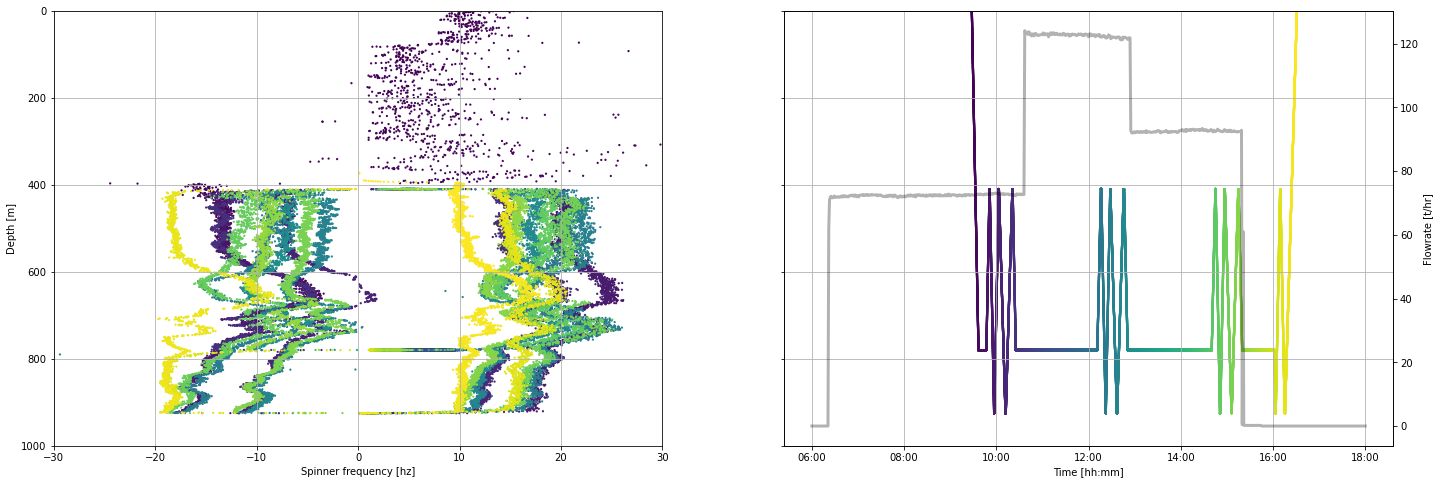

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,8),sharey=True)

ax1.scatter(pts.frequency_hz, pts.depth_m, c = pts.timestamp, s = 5, linewidths = 0)
ax2.scatter(pts.datetime, pts.depth_m, c = pts.timestamp, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 3, alpha = 0.3, 
    label='Surface pump flowrate')

ax1.set_ylim(1000,0)
ax1.set_xlim(-30,30)

ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('Spinner frequency [hz]')

ax2.set_xlabel('Time [hh:mm]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.set_ylabel('Flowrate [t/hr]')

for ax in [ax1, ax2]:
    ax.grid()

### 16.3.2 Visualise spinner by time

When we plot spinner frequency by time we can see the sequence of up and down runs of the tool inside the well. A steady tool speed is maintained within each of these runs. However, as the tool approaches the bottom and top of the logged interval, it slows down before it stops. As we zoom into the data by changing the time interval plotted, we see where the tool is slowing before it stops.

''

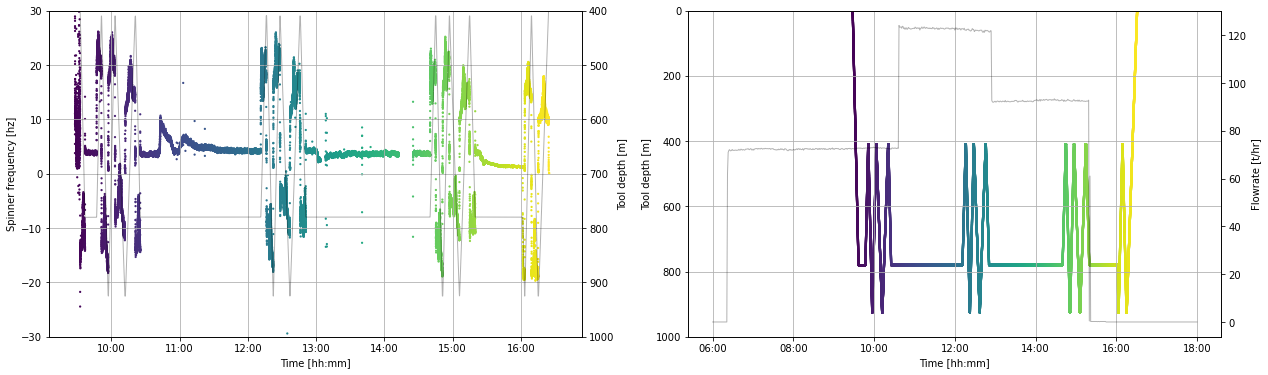

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(21,6))

ax1.scatter(pts.datetime, pts.frequency_hz, c = pts.timestamp, s = 5, linewidths = 0)
ax2.scatter(pts.datetime, pts.depth_m, c = pts.timestamp, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 1, alpha = 0.3, 
    label='Surface pump flowrate')

ax4 = ax1.twinx()
ax4.plot(pts.datetime, pts.depth_m, 
    c='k', linestyle = '-', linewidth = 1, alpha = 0.3, # edit linewidth to make visible
    label='Tool depth [m]')

ax4.set_ylim(1000,-1000)
ax4.set_ylabel('Tool depth [m]')

ax1.set_ylim(-30,30)
ax1.set_ylabel('Spinner frequency [hz]')

ax2.set_ylim(1000,0)
ax2.set_ylabel('Tool depth [m]')

for ax in [ax1,ax2]:
    ax.set_xlabel('Time [hh:mm]')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3.set_ylabel('Flowrate [t/hr]')

for ax in [ax1, ax2]:
    ax.grid()

ax4.set_ylim(1000,400)


# Uncomment the code below
# Edit the times to limit the plot to the desired time period

#start_time = pd.to_datetime('2020-12-11 09:30:00')
#end_time = pd.to_datetime('2020-12-11 10:30:00')

#ax1.set_xlim(start_time,end_time)
;

## 16.4 Clean data

We will remove data acquired when the tool is stationary or slowing and the data acquired while in the cased sections. 

To understand the method used here and how we decided which data to filter, refer to bonus-filter-by-toolspeed.ipynb

In [13]:
moving_pts = pts[
    (pts.speed_mps > 0.9 ) & (pts.speed_mps < pts.speed_mps.max()) | 
    (pts.speed_mps > pts.speed_mps.min() ) & (pts.speed_mps < -0.9)
    ]

production_shoe = 462.5  

clean_pts = moving_pts[(moving_pts.depth_m < moving_pts.depth_m.max()) & (moving_pts.depth_m > production_shoe)]

We now have a new working dataframe called clean_pts that will be used in the analysis. 

If we repeat the same plot we made in Section 14.3.2, we can see what data has been removed. 

''

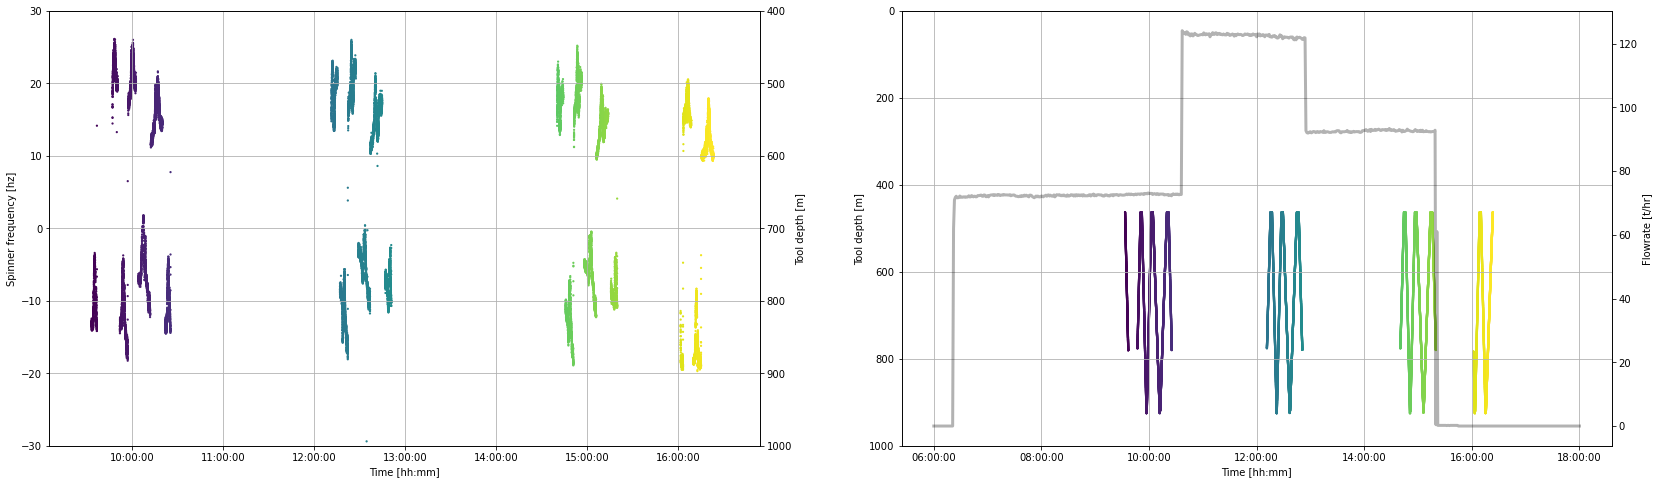

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(28,8))

ax1.scatter(clean_pts.datetime, clean_pts.frequency_hz, c = clean_pts.timestamp, s = 5, linewidths = 0)
ax2.scatter(clean_pts.datetime, clean_pts.depth_m, c = clean_pts.timestamp, s = 5, linewidths = 0)

ax3 = ax2.twinx()
ax3.plot(flowrate.datetime, flowrate.flow_tph, 
    c='k', linestyle = '-', linewidth = 3, alpha = 0.3, 
    label='Surface pump flowrate')

ax4 = ax1.twinx()
ax4.plot(pts.datetime, pts.depth_m, 
    c='k', linestyle = '-', linewidth = 0, alpha = 0.3,  # edit linewidth to make visible
    label='Tool depth [m]')
ax4.set_ylim(1000,400)
ax4.set_ylabel('Tool depth [m]')

ax1.set_ylim(-30,30)
ax1.set_ylabel('Spinner frequency [hz]')

ax2.set_ylim(1000,0)
ax2.set_ylabel('Tool depth [m]')

for ax in [ax1,ax2]:
    ax.set_xlabel('Time [hh:mm]')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax3.set_ylabel('Flowrate [t/hr]')

for ax in [ax1, ax2]:
    ax.grid()

# Uncomment the code below
# Edit the times to limit the plot to the desired time period

#start_time = pd.to_datetime('2020-12-11 14:30:00')
#end_time = pd.to_datetime('2020-12-11 15:30:00')

#ax1.set_xlim(start_time,end_time)

;

***

## 17. Select data by flow rate

The cross-plot analysis is done using PTS tool passes conducted at a single surface pump flow rate. 

In this section we generate a dataframe of PTS data for each flow rate using an interactive plotting tool.

### 17.1 Interactive plot

Use the sliders on the interactive plot below to find a time before (start, green) and after (end, red) each series of PTS tool passes that were conducted at a single flow rate. Because we have removed the stationary and slowing tool data, the slider values need to be close to the start and end of our desired data, but they not need to be exact.

In [15]:

min_timestamp = pts.timestamp.iloc[0]
max_timestamp = pts.timestamp.iloc[-1]

def subselect_plot(start_value, stop_value):
    f,ax = plt.subplots(1,1, figsize = (20,6))
    ax.scatter(clean_pts.timestamp, clean_pts.depth_m,
        c = 'k', s = 1, linewidths = 0, label = 'Tool depth')
    ax1 = ax.twinx()
    ax1.plot(flowrate.timestamp, flowrate.flow_tph, 
        ':', c='k', label='Surface pump flowrate')
    ymin = pts.depth_m.min()
    ymax = pts.depth_m.max() + 100
    ax.vlines(start_value, ymin, ymax, color='tab:green')
    ax.vlines(stop_value, ymin, ymax, color='tab:red')
    ax.set_ylim(pts.depth_m.max() + 100, 0)
    ax.set_xlabel('Timestamp [sec]')
    ax.set_ylabel('Tool depth [m]')
    ax1.set_ylabel('Flowrate [t/hr]')

result = interactive(subselect_plot,
         
         start_value = FloatSlider
         (
             value = (max_timestamp - min_timestamp)/3 + min_timestamp,
             description = 'start',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%'),
             ),
          
          stop_value = FloatSlider
          (
             value = (max_timestamp - min_timestamp)/2 + min_timestamp, 
             description = 'stop',
             min = min_timestamp, 
             max = max_timestamp, 
             step = 10, 
             continuous_update=False,
             layout = Layout(width='80%')
             )
)

display(result);


interactive(children=(FloatSlider(value=1607640519.744, continuous_update=False, description='start', layout=L…

In [53]:
print(
    'start =',result.children[0].value, '# which is', datetime.fromtimestamp(result.children[0].value), 
    '\nstop =', result.children[1].value, '# which is', datetime.fromtimestamp(result.children[1].value),
    )

start = 1607650664.448 # which is 2020-12-11 14:37:44.448000 
stop = 1607653034.448 # which is 2020-12-11 15:17:14.448000


### 17.2 Record your analysis

We want to make our completion test analysis repeatable and easy to come back to and check. Subsequently, we take the range selected above and manually define objects for making a PTS dataframe with only one flow rate.  

We could have defined the start and stop objects used to generate our single rate dataframes as the result.childern\[0\].value and result.childern\[1\].value objects. But if we did this, you would lose your work because these ipywidget results change every time the sliders are moved or the notebook is re-run. 

Copy-paste the timestamps printed by the cell above into the markdown cell below to preserve our analysis. We can also take this opportunity to record any metadata that will help others (or our future self) understand our analysis.  

**First pump flow rate (lowest rate)**

    Insert your results here

**Second pump flow rate (highest rate)**

    Insert your results here

**Third pump flow rate (middle rate)**

    Insert your results here

The how the pumps were shut off early in the third rate so we selected data from before they were shut off.


### 17.3 Make a PTS dataframe for each flow rate

Select the data from the clean_pts dataframe for each of the three flow rates using the timestamps generated with the interactive plot

#### 17.3.1 First flow rate (lowest pump rate)

In [43]:
# First flow rate

start = 1607632004.448 
stop = 1607635844.448  

pts_first_rate = clean_pts[
    (clean_pts.datetime > datetime.fromtimestamp(start)) 
    & (clean_pts.datetime < datetime.fromtimestamp(stop))
]

pts_first_rate.tail(2)

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,flow_tph,interpolated_flow_tph
14009,1.607636e+09,779.75850,1.075846,162.95807,-0.606680,78.04247,37.485870,-3.604245,2020-12-11 10:25:22.656,NaN,72.422936
14010,1.607636e+09,779.76215,0.997284,146.49721,-0.607066,78.05295,37.492332,7.758757,2020-12-11 10:25:22.656,NaN,72.424735


#### 17.3.2 Second flow rate (highest pump rate)

In [47]:
# Second flowrate

start = 1607641584.448 
stop = 1607644334.448  

pts_second_rate = clean_pts[
    (clean_pts.datetime > datetime.fromtimestamp(start)) 
    & (clean_pts.datetime < datetime.fromtimestamp(stop))
]

pts_second_rate.head(2)

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,flow_tph,interpolated_flow_tph
39241,1.607642e+09,775.77325,-0.924612,156.50272,-0.614624,50.501522,37.40507,14.772270,2020-12-11 12:11:28.608,NaN,122.713843
39242,1.607642e+09,775.48550,-0.941982,158.09349,-0.614432,50.517090,37.37814,15.164833,2020-12-11 12:11:28.608,NaN,122.713843


#### 17.3.3 Third flow rate (middle pump rate)

In [50]:
# Third flowrate

start = 1607650554.448  
stop = 1607653034.448  


pts_third_rate = clean_pts[
    (clean_pts.datetime > datetime.fromtimestamp(start)) 
    & (clean_pts.datetime < datetime.fromtimestamp(stop))
]

pts_third_rate.tail(2)

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,datetime,flow_tph,interpolated_flow_tph
83473,1.607653e+09,572.2503,1.311401,109.704025,-0.609779,24.982096,17.402770,-9.620529,2020-12-11 15:17:14.208,NaN,92.428477
83474,1.607653e+09,572.5636,1.310956,109.223180,-0.609779,24.994959,17.422161,-9.403336,2020-12-11 15:17:14.208,NaN,92.428477


#### 17.3.4 Plot data from one flow rate

The plot below offers us the opportunity to look at the raw data we have just selected. 

Edit the pts_df and flow_df objects to switch between the three flow rate dataframes we generated above.

Note how the flow rate is approximately the same but does vary with time. The right-hand plot nicely shows how the spinner frequency (hertz) various as the tool is run at different speeds up (positive values) and down (negative values) inside the well. 

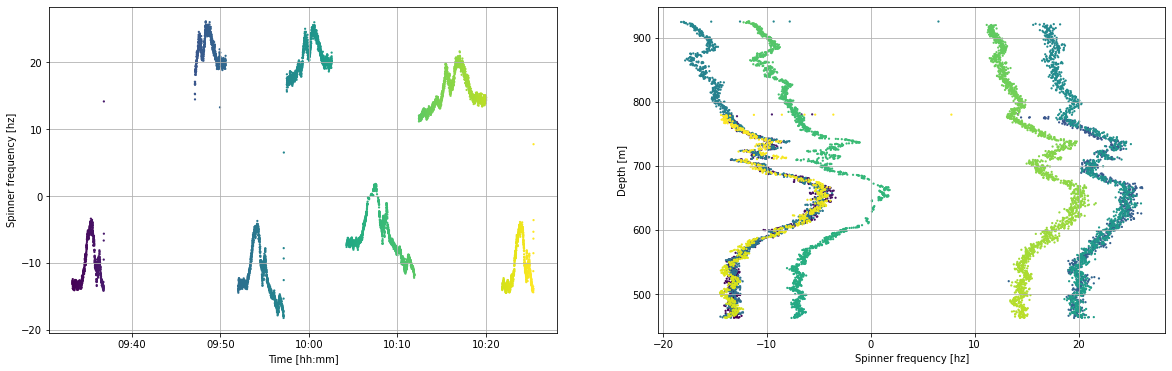

In [51]:
# define which dataframe you want to plot
pts_df = pts_first_rate

# test plot the data
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))

ax1.scatter(pts_df.datetime, pts_df.frequency_hz, 
    c = pts_df.timestamp, s = 5, linewidths = 0)

ax2.scatter(pts_df.frequency_hz, pts_df.depth_m, 
    c = pts_df.timestamp, s = 5, linewidths = 0)

ax1.set_ylabel('Spinner frequency [hz]')
ax1.set_xlabel('Time [hh:mm]')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2.set_xlabel('Spinner frequency [hz]')
ax2.set_ylabel('Depth [m]')

for ax in [ax1,ax2]:
    ax.grid()

***

# 18. Fluid velocity analysis

We find the fluid velocity inside the well by determining for a given depth the speed at which the PTS tool would be travelling match the speed of the fluid inside the well and therefore result in the spinner stopping. 

In summary, the cross-plot method includes:
1. Define the cross-plot interval for analysis
2. Select the PTS data inside that interval
3. Generate a linear interpolation of frequency (x) and tool speed (y)
4. Return the y-intercept, which is the zero spin or fluid velocity
5. Return data that helps us to QA/QC and clean the analysis results (R2, data used in the model fit, number of data points)
6. QA/QC result
7. Clean result to remove suspect values

This is done for each pump flow rate and the results are interpreted along with the temperature profiles to identify feed zones.

## 18.1 Illustrate the cross-plot method

In this section, we use one meter of data to illustrate the cross-plot method implemented in this notebook. 

In [21]:
interval_top = 700 # shallowest depth in the cross-plot analysis interval
interval_bottom = 701 # deepest depth in the cross-plot analysis interval

selected_data = pts_second_rate[
    (pts_second_rate.depth_m > interval_top ) & (pts_second_rate.depth_m < interval_bottom)
    ]

selected_data = selected_data[selected_data['frequency_hz'].notna()]
selected_data = selected_data[selected_data['pressure_bara'].notna()]

linear_model = stats.linregress(selected_data.frequency_hz, selected_data.speed_mps)

test_slope = linear_model[0]
test_intercept = linear_model[1] # this is the tool speed that matches the fluid velocity
test_rvalue = linear_model[2] # this is how well the model fits the data and will be a filter

print(test_rvalue, test_rvalue**2, test_intercept) 

-0.9996426532611656 0.999285434219023 0.5868381686452437


**Linear regression**

We find this speed of zero spinner frequency using linear interpolation. We plan to add a bi-linear interpolation method to this notebook in future. There are many Python packages that can be used to do a linear regression. We selected the stats.linregress because it is fast and easy to use. 

The stats.linregress method returns the R value, which is a number between 1 and -1 that describes the relationship between independent (x) and dependant (y) variable:
- -1 indicates that an **increase** in x has an associated **decrease** in y
- +1 indicates that an **increase** in x has an associated **increase** in y
- 0 indicates there is **no relationship** between x and y

The $R^2$ value generally tells us how related the two variables are: More specifically, it describes the proportion of variation in the dependant variable (y) that can be predicted from the independent variable (x). $R^2$ varies between 0 and 1 (a percentage). If $R^2 = 0.99$ then the model explains 99% of the variation can be explained. While an $R^2 = 0.3$ indicates that the model explains only 30% of the variation. However, these metrics may not well describe the shape of our data (check out [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)) and a percentage may not be easy to think about in relation to our data. 

Root mean squared error would probably be a better metric of fit quality (and is on our to-do list), but because we are working with a small number of data in each interval we can use R2 as a nice, computationally cheap approach to evaluating fit quality. 


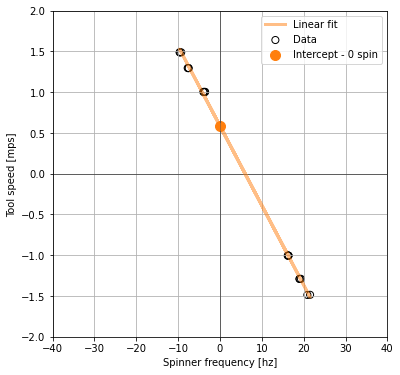

In [22]:
fig, (ax) = plt.subplots(1, 1,figsize=(6,6))
   
ax.scatter(selected_data.frequency_hz, selected_data.speed_mps,
    color = 'none', edgecolors = 'k', marker='o', s = 50, linewidths = 1, label='Data')

model_y_vals = [] # y values using our model
for n in selected_data.frequency_hz:
    model_y_vals.append(test_slope * n + test_intercept)

ax.plot(selected_data.frequency_hz, model_y_vals, 
    color='tab:orange', linestyle='-', linewidth=3, alpha=0.5, label='Linear fit')

ax.scatter(0,test_intercept,
    color='tab:orange', s = 100, label='Intercept - 0 spin')

ax.hlines(0, -40, 40, color = 'k', linewidth = 0.5)
ax.vlines(0, -2, 2, color = 'k', linewidth = 0.5)

ax.set_xlim(-40,40)
ax.set_ylim(-2,2)

ax.set_xlabel('Spinner frequency [hz]')
ax.set_ylabel('Tool speed [mps]')

ax.legend()

ax.grid()

In the above cross-plot, the y axis intercept from our linear_model is the fluid velocity: It is the point at which the logging tool is moving at the same speed as the fluid inside the well. 

We will do this many times down the well for a specified interval that depends on the resolution and quality of our data. In our sample case below, we will run this cross-plot fluid velocity analysis for each 0.5 m step. 

## 18.2 Functions for cross-plot analysis

The cross-plot analysis method in this notebook is a series of functions that are written assuming the dataframe column headers in this tutorial. They are not yet generalised. We have only just started working on this method and plan to refine it with time.

In [23]:
# To do: write an error for validation if the bottom is less than the top. Have it return an informative error. 

def analysis_steps(analysis_top, analysis_bottom, step_size):
    '''Make lists that define top and bottom of each analysis interval

    The cross_plot_analysis function requires that we pass in two numbers that 
    define the top and bottom of each data interval that we will do the
    cross-plot analysis on. 

    Args:   analysis_top: The shallowest depth of the spinner analysis interval
            analysis_bottom: The deepest depth of the spinner analysis interval
            step_size: the length of each cross-plot analysis interval within the spinner analysis interval

    Returns:    list_tops: List of top of each cross-plot analysis interval
                list_bots: List of the bottom of each cross-plot analysis interval   
    
    '''

    list_tops = np.arange(
        start = analysis_top, 
        stop = analysis_bottom - step_size, 
        step = step_size)

    list_bots = np.arange(
        start = analysis_top + step_size, 
        stop = analysis_bottom, 
        step = step_size)

    return list_tops, list_bots

# TODO: generalise this function so it does not matter what the column headers are

def cross_plot_analysis(dataframe, interval_top, interval_bottom):  
    '''
    Cross plot analysis of spinner frequency and tool speed data to find fluid velocity

    The method selects from the PTS dataframe between the interval_top and interval_bottom, 
    tests if there are any data in that interval and then calculates a linear model if there is. 
    The linear interpolation operates on spinner frequency (x) and tool speed (y) to find the fluid velocity (y-intercept).
    The method also returns the model slope, R squared (goodness of fit), and the number of data points used.

    Args:           dataframe, 
                    interval_top, 
                    interval_bottom

    Returns:        freq_data: (list) frequency data used in that cross-plot interval 
                    speed_data: (list) tool speed data used in that cross-plot interval 
                    linear_model[1]: liner model intercept which is equivalent to the fluid velocity
                    linear_model[0]: linear model slope 
                    r_squared: goodness of fit  
                    number_of_df_rows: number of dataframe rows used in that cross-plot interval

    '''  
    # select the cross-plot interval
    df = dataframe[(dataframe.depth_m > interval_top) & (dataframe.depth_m < interval_bottom)]
    # remove nan values
    df = df[df['frequency_hz'].notna()]
    df = df[df['pressure_bara'].notna()]
    # define data values for linear interpolation
    freq_data = df.frequency_hz.tolist()
    speed_data = df.speed_mps.tolist()
    # test if there is any kind of data in that cross-plot interval
    number_of_df_rows = df.shape[0]
    if number_of_df_rows > 1:
        # if there is data, do the linear regression
        linear_model = stats.linregress(df.frequency_hz, df.speed_mps)
        r_squared = linear_model[2]**2
    else: 
        # if there is no data, return None
        linear_model = [None,None]
        r_squared = None
    return freq_data, speed_data, linear_model[1], linear_model[0], r_squared, number_of_df_rows

# TODO: Need to test for the presence of data for the cross-plot intervals rather than the dataframe rows hack
# Currently I am assuming that the number of rows in the dataframe returned by the cross_plot_analysis function
# is equivalent to the number of values available for the cross-plot analysis. However, this may not be the case.

def calc_fluid_velocity(single_flowrate_df, top, bottom, step):
    '''
    Calculate fluid velocity from PTS data using cross-plot method for each defined step. 
    
    Note that this function has not yet been generalised, so it assumes the column headers generated by tutorial method.

    Args:       single_flowrate_df: (Pandas dataframe) generated using the method in this tutoral 
                top: (int) shallowest data depth 
                bottom: (int) deepest data depth 
                step: (int) interval thickness for each cross-plot
    
    Returns:    Pandas dataframe containing depth, fluid velocity (aka model intercept), 
                model slope, model R2, data in each cross-plot interval (observation number),
                spinner frequency and tool speed data contained in the cross-plot interval.
    '''
    # define the interval steps
    list_tops, list_bots = analysis_steps(top, bottom, step)

    # define the lists that results will be placed into during the for loop
    depth = [] # half way between top and bottom of step
    frequency_data = [] # spinner frequency data in that cross-plot interval
    speed_data = [] # tool speed data in that cross-plot interval
    fluid_velocity = [] # model intercept
    slope = [] # model slope
    rsquared = [] # goodness of fit
    obs_num = [] # number of observations in the step

    # calculate a linear model for each cross-plot interval using a for loop
    for top, bot in zip(list_tops, list_bots):
        d = (bot - top)/2 + top 
        depth.append(d)
        fd, sd, v, s, r, obs = cross_plot_analysis(single_flowrate_df, top, bot)
        frequency_data.append(fd)
        speed_data.append(sd)
        fluid_velocity.append(v)
        slope.append(s)
        rsquared.append(r)
        obs_num.append(obs) 

    # turn the results lists into a Pandas dataframe
    df = pd.DataFrame()
    df['depth_m'] = depth
    df['intercept_velocity_mps'] = fluid_velocity
    df['slope'] = slope
    df['r_squared'] = rsquared
    df['obs_num'] = obs_num
    df['frequency_data_hz'] = frequency_data
    df['speed_data_mps'] = speed_data

    return df


### 18.3 Calculate fluid velocity

Call the wrapper function calc_fluid_velocity to find the fluid velocity for each of our flow rates. 

It is useful to trial this method for various steps sizes and see what happens to the R2 and number of values in each cross-plot interval. 

In [24]:
fvelocity_first_rate = calc_fluid_velocity(pts_first_rate, top = 460, bottom = 925, step = 0.5)
fvelocity_second_rate = calc_fluid_velocity(pts_second_rate, top = 460, bottom = 925, step = 0.5)
fvelocity_third_rate = calc_fluid_velocity(pts_third_rate, top = 460, bottom = 925, step = 0.5)

In [25]:
fvelocity_first_rate.tail(1)

,depth_m,intercept_velocity_mps,slope,r_squared,obs_num,frequency_data_hz,speed_data_mps
928,924.25,0.05906,-0.079097,0.998736,4,"[-18.032711, -18.258533, -11.898336, -11.855001]","[1.4979827, 1.4911093, 0.9983444, 0.99812824]"


In [26]:
fvelocity_second_rate.tail(1)

,depth_m,intercept_velocity_mps,slope,r_squared,obs_num,frequency_data_hz,speed_data_mps
928,924.25,0.314028,-0.065909,0.965465,5,"[-17.913994, -17.784054, -11.185165, -10.50706...","[1.5034931, 1.5020548, 0.981567, 0.97703344, 0..."


In [27]:
fvelocity_third_rate.tail(1)

,depth_m,intercept_velocity_mps,slope,r_squared,obs_num,frequency_data_hz,speed_data_mps
928,924.25,-2.428468,-0.212184,1.0,2,"[-18.510809, -18.301046]","[1.4992332, 1.4547248]"


### 18.4 Visulise raw fluid velocity results

Below we plot the results for one flow rate. Edit the object fluid_velocity_df to change the results set you would like to view.

In [28]:
pts_first_rate.describe()

,timestamp,depth_m,speed_mps,cweight_kg,whp_barg,temp_degC,pressure_bara,frequency_hz,flow_tph,interpolated_flow_tph
count,8.626000e+03,8626.000000,8626.000000,8626.000000,8626.000000,8626.000000,8626.000000,8427.000000,6.000000,8626.000000
mean,1.607634e+09,671.980139,0.155187,128.064108,-0.606378,51.221880,27.096128,3.361954,72.637024,72.768503
std,8.370405e+02,126.692486,1.303722,20.264200,0.000785,22.911469,12.231223,14.407104,0.037445,0.170580
min,1.607632e+09,462.573030,-1.534443,88.490944,-0.608811,23.832254,6.676053,-18.258533,72.602842,72.262165
25%,1.607634e+09,564.207025,-1.014612,113.593420,-0.606874,26.993438,16.690939,-10.191675,72.602842,72.658273
50%,1.607634e+09,666.196195,1.001770,126.178390,-0.606389,45.347706,26.596482,-4.107344,72.637024,72.807935
75%,1.607635e+09,767.858400,1.492300,142.254490,-0.605905,77.846090,36.367360,18.303049,72.671206,72.890842
max,1.607636e+09,925.065900,1.528768,189.689560,-0.603774,86.092140,51.359390,26.134710,72.671206,73.148898


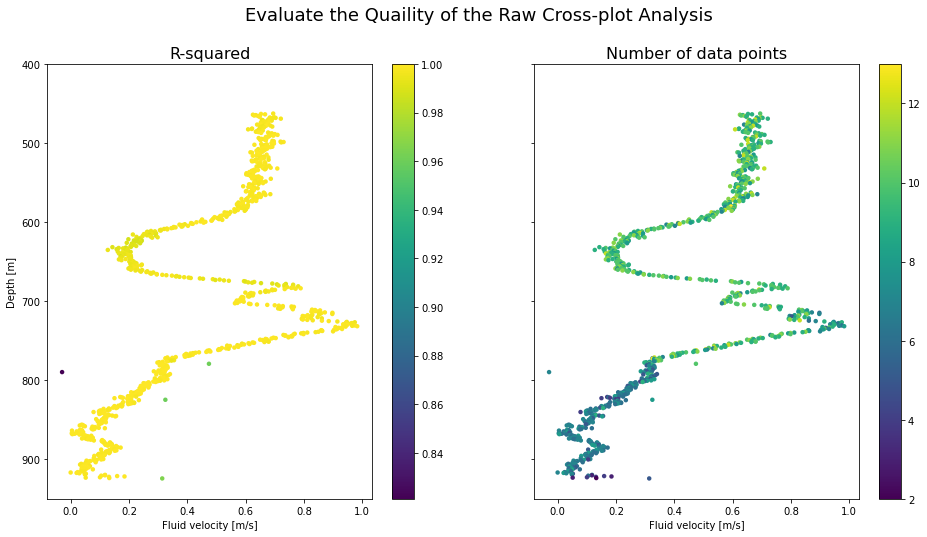

In [29]:
fluid_velocity_df = fvelocity_second_rate # the results dataframe to be plotted

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharey=True)

fig.suptitle('Evaluate the Quaility of the Raw Cross-plot Analysis', fontsize=18)

ax1.set_title('R-squared', fontsize=16)
im1 = ax1.scatter(fluid_velocity_df.intercept_velocity_mps, fluid_velocity_df.depth_m,
    c = fluid_velocity_df.r_squared, s = 20, linewidths = 0)
fig.colorbar(im1,ax=ax1)

ax2.set_title('Number of data points', fontsize=16)
im2 = ax2.scatter(fluid_velocity_df.intercept_velocity_mps, fluid_velocity_df.depth_m,
    c = fluid_velocity_df.obs_num, s = 20, linewidths = 0)
fig.colorbar(im2,ax=ax2)

ax1.set_ylabel('Depth [m]')
ax1.set_ylim(950,400)

for ax in [ax1,ax2]:
    ax.set_xlabel('Fluid velocity [m/s]')

### 18.5 Clean the fluid velocity data

We will use the number of values in the cross-plot interval and the R2 value to remove from our results dataframe those values that are likely to be suspect. Use the plots above to set limits on these filters.

#### 18.5.1 First pump flow rate

In [30]:
# first rate

# Filter data based on R2 value
fvelocity_first_rate_trimmed = fvelocity_first_rate[(fvelocity_first_rate.r_squared > 0.98 )] # check filter

# filter data based on number of values
fvelocity_first_rate_trimmed = fvelocity_first_rate_trimmed[(fvelocity_first_rate_trimmed.obs_num > 6 )] # check filter


print('before filter =', fvelocity_first_rate.shape, 'after filter =', fvelocity_first_rate_trimmed.shape)

before filter = (929, 7) after filter = (785, 7)


#### 18.5.2 Second pump flow rate

In [31]:
# second rate

# Filter data based on R2 value
fvelocity_second_rate_trimmed = fvelocity_second_rate[(fvelocity_second_rate.r_squared > 0.98 )]

# filter data based on number of values
fvelocity_second_rate_trimmed = fvelocity_second_rate_trimmed[(fvelocity_second_rate_trimmed.obs_num > 6 )]


print('before filter =', fvelocity_second_rate.shape, 'after filter =', fvelocity_second_rate_trimmed.shape)

before filter = (929, 7) after filter = (780, 7)


#### 18.5.3 Third pump flow rate

In [32]:
# third rate

# Filter data based on R2 value
fvelocity_third_rate_trimmed = fvelocity_third_rate[(fvelocity_third_rate.r_squared > 0.98 )]

# filter data based on number of values
fvelocity_third_rate_trimmed = fvelocity_third_rate_trimmed[(fvelocity_third_rate_trimmed.obs_num > 6 )]

print('before filter =', fvelocity_third_rate.shape, 'after filter =', fvelocity_third_rate_trimmed.shape)

before filter = (929, 7) after filter = (775, 7)


### 18.4 Visualise cleaned fluid velocity results

Below we generate the same plot as used in Section 18.4 but with the dataframes that have had suspect cross-plot analysis results removed. 

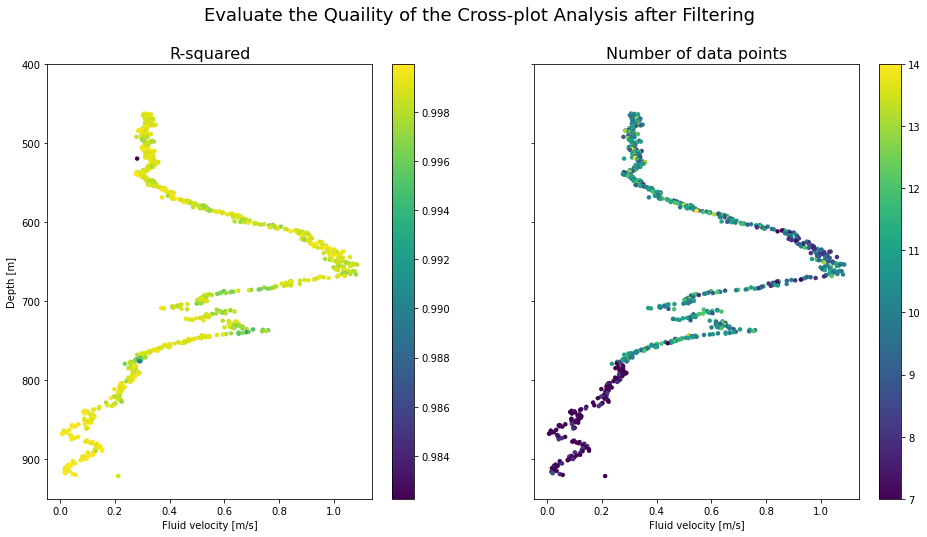

In [33]:
fluid_velocity_df = fvelocity_first_rate_trimmed # the results dataframe to be plotted


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), sharey=True)

fig.suptitle('Evaluate the Quaility of the Cross-plot Analysis after Filtering', fontsize=18)

ax1.set_title('R-squared', fontsize=16)
im1 = ax1.scatter(fluid_velocity_df.intercept_velocity_mps, fluid_velocity_df.depth_m,
    c = fluid_velocity_df.r_squared, s = 20, linewidths = 0)
fig.colorbar(im1,ax=ax1)

ax2.set_title('Number of data points', fontsize=16)
im2 = ax2.scatter(fluid_velocity_df.intercept_velocity_mps, fluid_velocity_df.depth_m,
    c = fluid_velocity_df.obs_num, s = 20, linewidths = 0)
fig.colorbar(im2,ax=ax2)

ax1.set_ylabel('Depth [m]')
ax1.set_ylim(950,400)

for ax in [ax1,ax2]:
    ax.set_xlabel('Fluid velocity [m/s]')   
    

### 18.5 Visulise each cross-plot analysis

The function below enables us to plot each cross-plot and save it to a folder so we can visually check the model fit.

In [34]:
def get_df_name(df):
    '''detect the dataframe name because sometimes df.name does not work'''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def make_crossplot_figures(dataframe, filename):
    '''Export all cross-plots for a dataframe into a folder in our present working directory
    
    WARNING: A folder will be made with the specified filename and
    if a folder already exists with that filename, it will be overwritten'''
    
    # make or overwite folder
    import os
    import shutil
    directory = filename
    parent_dir = os.getcwd() # detect present working directory
    path = os.path.join(parent_dir, directory)
    if os.path.exists(path): # if the directory already exists, remove it
        shutil.rmtree(path)
    os.mkdir(path) # make a directory in our present working directiory with our filename
    
    # make cross-plot for each row in the dataframe
    for i, row in dataframe.iterrows():
        frequency_data_hz = dataframe.iloc[i]['frequency_data_hz'] #.values.tolist()
        speed_data_mps = dataframe.iloc[i]['speed_data_mps'] #.values.tolist()
        slope = dataframe.iloc[i]['slope']
        intercept = dataframe.iloc[i]['intercept_velocity_mps']

        # calculate y values using our model
        model_y_vals = []
        for n in frequency_data_hz:
            model_y_vals.append(slope * n + intercept)

        # generate test plot
        fig, (ax) = plt.subplots(1, 1,figsize=(8,8))
        ax.set_title('Dataframe = {df_name}, Depth = {depth}, \n R2 = {rsquared:.4f}, Datapoint num = {datanumber}'.format(
            df_name = get_df_name(dataframe),
            depth = dataframe.iloc[i]['depth_m'], 
            rsquared = dataframe.iloc[i]['r_squared'], 
            datanumber = dataframe.iloc[i]['obs_num']))

        ax.scatter(frequency_data_hz, speed_data_mps,
            color = 'none', edgecolors = 'k', marker='o', s = 50, linewidths = 1)

        ax.plot(frequency_data_hz, model_y_vals, 
            color='tab:orange', linestyle='-', linewidth=3, alpha=0.5, label='Linear fit')

        ax.hlines(0, -40, 40, color = 'k', linewidth = 0.5)
        ax.vlines(0, -2, 2, color = 'k', linewidth = 0.5)

        ax.set_xlim(-40,40)
        ax.set_ylim(-2,2)

        ax.set_xlabel('Spinner frequency [hz]')
        ax.set_ylabel('Tool speed [mps]')

        ax.grid()
        
        plt.savefig(path + '/{depth}.png'.format(depth = dataframe.iloc[i]['depth_m']), 
                    dpi = 300,
                    facecolor='white', transparent=False)
        plt.close()

    return print('Cross-plot figures are saved in {folder}'.format(folder = path))

**Take care with the filename term in the make_crossplot_figures function: If this filename already exists, it will be deleted and a new one made.**

Uncomment the code in this cell to export the cross-plots. This code will take quite a whole to run because we are making many figures. 

In [35]:
# I don't reccomend running this cell in Google Colab
#make_crossplot_figures(fvelocity_second_rate, 'xplots_second_rate')

***

# 19. Combine the results and find the feed zones

In this section, we combine all the data together using a quite richly formatted plot to demonstrate the completion test data visualisation that's possible with Python.

In [36]:
# Use this method if you are running this notebook in Google Colab
heating_37days = pd.read_csv(r'/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-Temp-Heating37days.csv') 

# Use this method if you are running this notebook locally (Anaconda)
#heating_37days = pd.read_csv('Data-Temp-Heating37days.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/T21-Tutoral-WellTestAnalysis-main/Data-Temp-Heating37days.csv'

In [ ]:
# Convert bar gauge to bar atmosphere

heating_37days['pressure_bara'] = heating_37days.pres_barg - 1

heating_37days.head(2)

In [ ]:
# Calculate the BPD

# note that iapws uses SI units so some unit conversion is required

heating_37days['pressure_mpa'] = heating_37days.pressure_bara * 0.1  # convert pressure to MPa for ipaws

pressure = heating_37days['pressure_mpa'].tolist()
tsat = []
for p in pressure:
    saturation_temp = iapws.iapws97._TSat_P(p) - 273.15  # calculate saturation temp in Kelvin & convert to degC
    tsat.append(saturation_temp)
heating_37days['tsat_degC'] = tsat

heating_37days.head(2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)

# feedzone interpretaion
feedzones = [
    (560, 620), # 1
    (660, 690), # 2
    (705, 715), # 3
    (720, 740), # 4
    (745, 775), # 5
    (800, 835), # 6
    (850, 875), # 7
    (920, 930)  # 8
    ]

for ax in [ax1, ax2]: # plot all FZ
    for top, bottom in feedzones:
        ax.axhspan(top, bottom, color='tab:blue', alpha=.1)

biggest_feedzones = [
    (745, 775), # 5
    (800, 835), # 6
    ]

for ax in [ax1, ax2]: # highlight the largest FZ
    for top, bottom in biggest_feedzones:
        ax.axhspan(top, bottom, color='tab:blue', alpha=.4)

label_depth = [] # find the half way point for label depth
for top, bottom in feedzones:
    l = (bottom - top)/2 + top
    label_depth.append(l)

labels = ['FZ1','FZ2','FZ3','FZ4','FZ5','FZ6','FZ7','FZ8']    

for depth, label in zip(label_depth,labels): # plot FZ labels
    ax1.text(-0.16,depth,label,verticalalignment='center')


# fluid veolocity profiles for each flow rate generate by cross-plot analaysis
ax1.plot(fvelocity_first_rate_trimmed.intercept_velocity_mps,fvelocity_first_rate_trimmed.depth_m, 
    #marker = '.', # uncomment this to view the data points
    color = '#440154', linestyle = '-', linewidth = 2, #alpha = 0.8,
    label = '{rate:.0f} t/hr injection - velocity'.format(rate = pts_first_rate.flow_tph.mean()))
ax1.plot(fvelocity_third_rate_trimmed.intercept_velocity_mps,fvelocity_third_rate_trimmed.depth_m,
    #marker = '.',
    color = '#5ec962', linestyle = '-', linewidth = 2, #alpha = 0.8,
    label = '{rate:.0f} t/hr injection - velocity'.format(rate = pts_third_rate.flow_tph.mean())
    )
ax1.plot(fvelocity_second_rate_trimmed.intercept_velocity_mps,fvelocity_second_rate_trimmed.depth_m,
    #marker = '.',
    color = '#21918c', linestyle = '-', linewidth = 2, #alpha = 0.8,
    label = '{rate:.0f} t/hr injection - veolcity'.format(rate = pts_second_rate.flow_tph.mean()))

# completion test temp data
ax2.scatter(clean_pts.temp_degC, clean_pts.depth_m,     
    c = clean_pts.timestamp, s = 5, linewidths = 0, alpha = 0.5)

# false plots to generate the legand
ax2.plot(0, 0, color = '#440154', linewidth = 2, # purple
    label = '{rate:.0f} t/hr injection - temp'.format(rate = pts_first_rate.flow_tph.mean()))
ax2.plot(0, 0, color = '#5ec962', linewidth = 2, # blue
    label = '{rate:.0f} t/hr injection - temp'.format(rate = pts_third_rate.flow_tph.mean()))
ax2.plot(0, 0, color = '#21918c', linewidth = 2, # green
    label = '{rate:.0f} t/hr injection - temp'.format(rate = pts_second_rate.flow_tph.mean()))
ax2.plot(0, 0, color = '#fde725', linewidth = 2, # yellow
    label = 'Day 0 shut - temp')


# stable temp data
ax2.plot(heating_37days.temp_degC, heating_37days.depth_m, 
    color = '#fd7b25', linewidth = 2,
    label = 'Day 37 shut - temp')

# saturation temp for the stable pressure profile assuming pure water
ax2.plot(heating_37days.tsat_degC, heating_37days.depth_m, 
    linestyle = ':', color = 'k', linewidth = 2,
    label = 'Day 37 shut - BPD')


production_shoe = 462.5 # 13 3/8 production casing shoe in meters measured depth (mMD) from the casing head flange (CHF)
top_of_liner = 425 # top of perforated 10 3/4 liner in meters measured depth (mMD) from CHF
terminal_depth = 946 # deepest drilled depth 
# the perforated liner is squatted on bottom but didn't quite make it all the way down (bottom of liner is 931 mMD)

# blank well casing
ax1.plot([-0.2, -0.2],[0, production_shoe],
    color = 'k', linewidth = 8, linestyle = '-')
ax2.plot([1, 1],[0, production_shoe],
    color = 'k', linewidth = 3, linestyle = '-')

# perforated well casing
ax1.plot([-0.18, -0.18],[top_of_liner, terminal_depth],     
    color = 'k', linewidth = 1.5, linestyle = '--')
ax2.plot([5, 5],[top_of_liner, terminal_depth],     
    color = 'k', linewidth = 1.5, linestyle = '--')


ax1.set_xlim(-0.2,1.2)
ax1.set_xlabel('Fluid velocity [m/s]')

ax2.set_xlim(0,300)
ax2.set_xlabel('Temperature [degC]')

ax1.set_ylim(950,300) #950,300 to show produciton zone
ax1.set_ylabel('Depth [m]')

for ax in [ax1,ax2]:
    ax.grid()
    ax.legend(loc='upper right')

#### This is not an easy well to interpret! 

- There are multiple feed zones and they interact differently at the various injection rates 
- In some feed zones, fluid always inflows into wellbore or exists the wellbore regardless of injection rate, while in other feed zones the flow direction switches when the injection rate is changed 
- The majority of the fluid is exiting at FZ5 and FZ6 (dark blue) 
- It is difficult to pinpoint whether there is a single major feed zone from this data alone (i.e., from the fluid velocity profiles and temperature profiles) 
- Pivoting of pressure profiles during progressive heat-up runs and combined analysis with borehole image log data would aid the interpretation, but this next analysis step is beyond the scope of our tutorial. 


|FZ number | Upper bound |  Lower bound | Features |
| --- | --- | --- | --- |
| 1 | 560 | 620 | Inflow at lowest injection rate and then outflow at the higher injection rates, as shown by: <br /> - Large increase fluid velocity at the low injection rate, which reverses for the other two higher rates, becoming a step down. <br /> - Increase in temperature gradient present for the first injection rate, which is not present for the two higher rates.|
| 2 | 660 | 690 | Small and high-velocity inflow of two-phase fluid, as seen at the highest two flow rates from: <br /> - Spikes in fluid velocity which subside below the feed zone. <br /> - Increases in temperature gradient.  |
| 3 | 705 | 715 | Small and high-velocity inflow of two-phase fluid, as seen at all three flow rates from: <br /> - Spikes in fluid velocity which subside below the feed zone. <br /> - Increases in temperature gradient. <br /> - Rapid heating at this depth after injection stops.  |
| 4 | 720 | 740 | Small and high-velocity inflow of two-phase fluid, as seen at all three flow rates from: <br /> - Spikes in fluid velocity which subside below the feed zone. <br /> - Increases in temperature gradient. <br /> - Rapid heating at this depth after injection stops. |
| 5 | 745 | 775 | Outflow of fluid from the wellbore, as seen at all three flow rates from: <br /> - Drop in fluid velocity. |
| 6 | 800 | 835 | Outflow of fluid from the wellbore, as seen at all three flow rates from: <br /> - Drop in fluid velocity. |
| 7 | 850 | 875 | Outflow of fluid from the wellbore, as seen at all three flow rates from: <br /> - Drop in fluid velocity. <br /> - Increase in temperature gradient. <br /> - Anomaly in heatup temperatures. |
| 8 | 920 | 930 | Must be some minor permeability at or below this depth, due to separation of the temperature profiles at different injection rates. |

***

#### What's next for completion test analysis with Python?

Future possible refinements of this fluid velocity method:
- If an open-hole calliper log was run, then we could limit the fluid velocity analysis to only those intervals that are in gauge
- Perhaps we could look for data where the spinner was stuck and remove these
- Use root mean squared error instead of R2 and consider other tests of the quality of our model fit

Do you have any suggestions?

Send your comments and feedback to irene@cubicearth.nz

***

You have finished the T21 geothermal well completion test tutoral. Well done!

***

<p><center>© 2021 <a href="https://www.cubicearth.nz/">Irene Wallis</a> and <a href="https://www.linkedin.com/in/katie-mclean-25994315/">Katie McLean</a> <a href="https://creativecommons.org/licenses/by/4.0/"</a></center></p>

<p><center>Licensed under the Apache License, Version 2.0</center></p>

***